In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
import pickle

import shutil

import os

from PIL import Image

In [2]:
#Defining directory base
base_dir = 'datasets/GearedorNot'
train_dir = os.path.join("datasets/working/train")
val_dir = os.path.join("datasets/working/val")
test_dir = os.path.join("datasets/working/test")

#creating directory for each category

for category in ['Wearing Safety Gear', 'Not Wearing Safety Gear']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

#función para dividir los datos
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE=0.8):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(f"{filename} is zero length, so ignoring.")   

    training_length = int(len(files) * SPLIT_SIZE)
    validation_length = int(len(files) * ((1 - SPLIT_SIZE) / 2))
    testing_length = int(len(files) - training_length - validation_length)


    #Bajaramos los ficheros
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[:training_length]
    validation_set = shuffled_set[training_length:training_length + validation_length]
    testing_set = shuffled_set[training_length + validation_length:]

    for filename in training_set:
        shutil.copy(os.path.join(SOURCE, filename), os.path.join(TRAINING, filename))

    for filename in validation_set:
        shutil.copy(os.path.join(SOURCE, filename), os.path.join(VALIDATION, filename))

    for filename in testing_set:
        shutil.copy(os.path.join(SOURCE, filename), os.path.join(TESTING, filename))


split_data(os.path.join(base_dir, 'Wearing Safety Gear'), os.path.join(train_dir, 'Wearing Safety Gear'), os.path.join(val_dir, 'Wearing Safety Gear'), os.path.join(test_dir, 'Wearing Safety Gear'))
split_data(os.path.join(base_dir, 'Not Wearing Safety Gear'), os.path.join(train_dir, 'Not Wearing Safety Gear'), os.path.join(val_dir, 'Not Wearing Safety Gear'), os.path.join(test_dir, 'Not Wearing Safety Gear'))


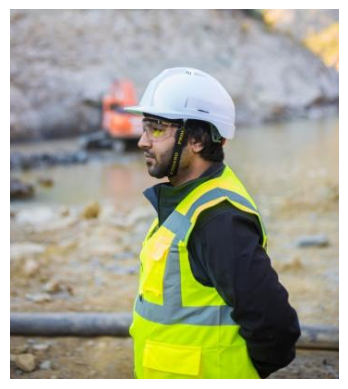

In [3]:
#Visualizar imagen:
image_path = 'datasets/working/train/Wearing Safety Gear/0bc36ce4-1979-4425-8de5-ece394de9f51.jpg'

image = Image.open(image_path)
plt.axis('off')
plt.imshow(image)
plt.show()

In [4]:
""" Iniciamos nuestro modelo """

' Iniciamos nuestro modelo '

In [5]:
#Inicialización
def initialization_parameters_deep(layers_dims):

    parameters = {}
    L = len(layers_dims)

    for l in range(1, L):

        #He initialization
        parameters["W"+str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        parameters["b"+str(l)] = np.zeros((layers_dims[l], 1))

    return parameters


In [6]:
""" Mini-Batch Gradient Descent  (mejora 1)"""  
import math

def random_mini_batches(X, Y, mini_batch_size=32):

    m = X.shape[1]
    mini_batches = []

    #Paso 1: Creamos versión shuffled del set de entrenamiento
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    #Paso 2: Partir la mezcla en minibatchs de tamaño 'mini_batch_size'
    inc = mini_batch_size
    num_complete_minibatch = math.floor(m / mini_batch_size)

    for k in range(0,num_complete_minibatch):

        mini_batch_X = shuffled_X[:, k*inc : (k+1)*inc]
        mini_batch_Y = shuffled_Y[:, k*inc : (k+1)*inc]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[:, num_complete_minibatch*inc : ]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatch*inc : ]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [7]:
""" Momentum para Gradient Descent (mejora 2)"""
#When using minibatches for update we make the update just with a subset of examples. Momentum takes in account past gradients to smooth the 
# update.

#Step 1 - Inicializar velocity 'v'
def initilize_velocity(parameters):
    
    L = len(parameters) // 2

    v = {}

    for l in range(1,L+1):

        v["dW"+str(l)] = np.zeros((parameters["W"+str(l)].shape))
        v["db"+str(l)] = np.zeros((parameters["b"+str(l)].shape))

    return v

#Step 2 - Update parameters with momentum
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):

    L = len(parameters) // 2

    for l in range(1,L+1):

        #Exponentially Weighted Averages
        v["dW"+str(l)] = beta * v["dW"+str(l)] + (1-beta) * grads["dW"+str(l)]
        v["db"+str(l)] = beta * v["db"+str(l)] + (1-beta) * grads["db"+str(l)]

        #Update of parameters with momentum
        parameters["W"+str(l)] = parameters["W"+str(l)] - learning_rate * v["dW"+str(l)]
        parameters["b"+str(l)] = parameters["b"+str(l)] - learning_rate * v["db"+str(l)]

    return parameters, v



In [8]:
""" Adam Algorithm - Momentum + RMSProp (mejora 3)"""

#Step 1: Initialize with Adam: v --> exponentially weighted average. s --> exponentially weighted average of the squares
def initialize_parameters_adam(parameters):

    L = len(parameters) // 2

    v = {}
    s = {}

    for l in range(1,L+1):

        v["dW" + str(l)] = np.zeros((parameters["W"+str(l)].shape))
        v["db" + str(l)] = np.zeros((parameters["b"+str(l)].shape))
        s["dW" + str(l)] = np.zeros((parameters["W"+str(l)].shape))
        s["db" + str(l)] = np.zeros((parameters["b"+str(l)].shape))
        
    return v, s

#Step 2: Calculates the respective exponentially weighted average of past gradient before and after bias correction and updates the parameters

def update_parameters_with_adam(parameters, grads, v, s, t, beta1, beta2, learning_rate, epsilon):
    
    L = len(parameters) // 2

    v_corrected = {}
    s_corrected = {}

    for l in range(1, L+1):

        #exponential weighted average 'v' and squared 's'
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1-beta1) * grads["dW"+str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1-beta1) * grads["db"+str(l)]

        v_corrected["dW"+str(l)] = v["dW"+str(l)] / (1-np.power(beta1,t))
        v_corrected["db"+str(l)] = v["db"+str(l)] / (1-np.power(beta1,t))

        s["dW"+str(l)] = beta2 * s["dW"+str(l)] + (1 - beta2) * np.power(grads["dW"+str(l)], 2)
        s["db"+str(l)] = beta2 * s["db"+str(l)] + (1 - beta2) * np.power(grads["db"+str(l)], 2)
        
        #with bias correction
        s_corrected["dW" + str(l)] = s["dW"+str(l)] / (1-np.power(beta2,t))
        s_corrected["db" + str(l)] = s["db"+str(l)] / (1-np.power(beta2,t))

        #update
        parameters["W"+str(l)] = parameters["W"+str(l)] - learning_rate * (v_corrected["dW"+str(l)] / (np.sqrt(s_corrected["dW"+str(l)]) + epsilon))
        parameters["b"+str(l)] = parameters["b"+str(l)] - learning_rate * (v_corrected["db"+str(l)] / (np.sqrt(s_corrected["db"+str(l)]) + epsilon))

    return parameters, v, s

In [9]:
""" Regularization -- Reduce Overfitting --> L2"""

#Step 1: compute the cost
def compute_cost_with_regularization(AL, Y, parameters, lambd):

    m = Y.shape[1]

    cross_entropy_cost = bce_compute(AL,Y)

    L2_regularization_cost = 0

    for key in parameters:
        if 'W' in key:
            L2_regularization_cost += np.sum(np.square(parameters[key]))


    L2_regularization_cost = (lambd / (2 * m)) * L2_regularization_cost

    cost = cross_entropy_cost + L2_regularization_cost

    return  cost

In [10]:
"""  Forward Propagation Module """

'  Forward Propagation Module '

In [44]:
#Paso 1: calculo de la transformación lineal
def forward_linear_prop(A_prev, W, b):

    z = np.dot(W,A_prev) + b

    cache = (A_prev, W, b)


    return z, cache

#Funciones activadoras
def relu(z):
    
    a = np.maximum(0,z)

    cache = z

    return a, cache

def sigmoid(z):

    a = 1 / (1 + np.exp(-z))

    cache = z
    
    return a, cache


#Paso 2: Activacion
def linear_activation_forward(A_prev, W, b, activation):

    Z, cache_linear = forward_linear_prop(A_prev, W, b)

    if activation == "relu":
        a, cache_activation = relu(Z)
    
    elif activation == 'sigmoid':
        a, cache_activation = sigmoid(Z)

    cache = (cache_linear, cache_activation)

    return a, cache

In [13]:
#Paso 3: Modelo de la propagación hacia delante

def L_model_forward(X, parameters):

    caches = []

    L = len(parameters) // 2
    A = X
    

    for l in range(1, L):
        
        A_prev = A

        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
        caches.append(cache)

    #Ultima capa, sigmoid:
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "sigmoid")
    caches.append(cache)

    return AL, caches

In [14]:
""" Cost Function Module """
def bce_compute(AL, Y):

    m = Y.shape[1]

    cost = -1/m * np.sum( Y * np.log(AL) + (1 - Y) * np.log(1-AL))

    return np.squeeze(cost)

In [15]:
""" Backward Propagation Module """

' Backward Propagation Module '

In [16]:
#Activation functions backwards:
def relu_backward(dA, cache):

    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
 
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


#Paso 1 cálculo linear backward:
def linear_backward(cache, dZ):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA = np.dot(W.T, dZ)

    return dW, db, dA

#Paso 2: Cálculo de la activación backward:
def linear_backward_prop(dA, cache, activation):

    linear_cache, activation_cache = cache

    dA_prev = None
    dW = None
    db = None

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(linear_cache, dZ)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(linear_cache, dZ)

    return dW, db, dA_prev

In [ ]:
#Paso 3: Modelo backward.
def L_model_backward(AL, caches, Y, lambd):

    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    #Tratamos la última capa.
    dAL = - (np.divide(Y,AL) - np.divide(1-Y, 1-AL))

    current_cache = caches[L-1]
    linear_cache, _ = current_cache
    _, W, _ = linear_cache
    dW_prev, db_prev, dA_prev = linear_backward_prop(dAL, current_cache, activation="sigmoid")

    #Añadimos término de L2 - Regularización
    dW_prev += (lambd / m) * W

    grads["dW"+str(L)] = dW_prev
    grads["db"+str(L)] = db_prev
    grads["dA"+str(L-1)] = dA_prev

    for l in reversed(range(L-1)):

        current_cache = caches[l]
        linear_cache, _ = current_cache
        _, W, _ = linear_cache

        dW_prev, db_prev, dA_prev = linear_backward_prop(grads["dA"+str(l+1)], current_cache, activation="relu")

        #Añadimos término de L2 - Regularización
        dW_prev += (lambd / m) * W

        grads["dW"+str(l+1)] = dW_prev
        grads["db"+str(l+1)] = db_prev
        grads["dA"+str(l)] = dA_prev
    
    return grads

In [17]:
#Paso 4: Update parameters:
def update_parameters(params, grads, learning_rate):

    parameters = copy.deepcopy(params)

    L = len(parameters) // 2

    for l in range(L):
        
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate * grads["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate * grads["db"+str(l+1)]

    return parameters

In [18]:
""" Arquitectura del modelo completo """

' Arquitectura del modelo completo '

In [19]:
def deep_neuronal_model(X, Y, layers_dims, epsilon, lambd, beta1 = 0.9, beta2 = 0.99, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    costs = [] # registro de costo

    #inicializamos parámetros
    parameters = initialization_parameters_deep(layers_dims)
    #v = initilize_velocity(parameters) # inicializamos velocity 'v' (mejora 2)

    v, s = initialize_parameters_adam(parameters)

    #Entrenamos
    for i in range(num_iterations):

        #Definimos los minibatches (mejora 1)
        mini_batches = random_mini_batches(X, Y, mini_batch_size=64)
        t = 1
        for mini_batch in mini_batches: # (mejora 1)
            
            #Forward_prop - 1
            AL, caches = L_model_forward(X, parameters) 

            #Computation of cost - 2
            cost = compute_cost_with_regularization(AL, Y, parameters, lambd)
            costs.append(cost)

            #Backward_prop - 3
            grads = L_model_backward(AL, caches, Y, lambd)

            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, beta1, beta2, learning_rate, epsilon)
            t = t +1
            #Update parameters - 4  -- (con mejora 2)            
            #parameters, v = update_parameters_with_momentum(parameters,grads, v, beta, learning_rate)
            #parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 50 == 0:
            print(f"Cost after iteration {i}: {cost}")

    
    return parameters, costs


Tamaño orig: (356, 128, 128, 3)
Tamaño orig y: (356,)
Tamaño orig y (1,m): (356,)
(49152, 284)
train_x shape: (49152, 284)
train_y shape: (1, 284)
test_x shape: (49152, 72)
test_y shape: (1, 72)
Flattened image size: (49152,)


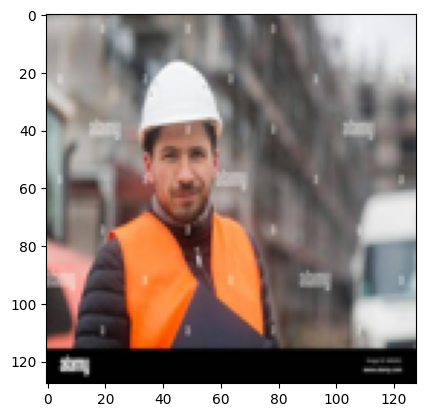

Label:  [1]


In [20]:
""" Preparar imagenes de entrenamiento """
from sklearn.model_selection import train_test_split

# Function to load and preprocess images
def load_images_from_folder(folder, label, image_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize the images
                if img_array.shape == (image_size[0], image_size[1], 3):  # Check if the shape is correct
                    images.append(img_array)
                    labels.append(label)
                else:
                    print(f"Skipping {filename}, incorrect shape: {img_array.shape}")
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
    return images, labels

# Define image size
image_size = (128, 128)

# Load images
wearing_safety_gear_path = 'datasets/working/train/Wearing Safety Gear'
not_wearing_safety_gear_path = 'datasets/working/train/Not Wearing Safety Gear'

wearing_images, wearing_labels = load_images_from_folder(wearing_safety_gear_path, 1, image_size)
not_wearing_images, not_wearing_labels = load_images_from_folder(not_wearing_safety_gear_path, 0, image_size)

# Combine and split the data manually
all_images = wearing_images + not_wearing_images
all_labels = wearing_labels + not_wearing_labels

# Convert to numpy arrays
all_set_x_orig = np.array(all_images) # your train set features
all_set_y_orig = np.array(all_labels) # your train set labels

print(f"Tamaño orig: {all_set_x_orig.shape}" )
print(f"Tamaño orig y: {all_set_y_orig.shape}" )

# Split the data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(all_set_x_orig, all_set_y_orig, test_size=0.2, random_state=42)

train_y = train_y.reshape((1, train_y.shape[0]))
test_y = test_y.reshape((1, test_y.shape[0]))

print(f"Tamaño orig y (1,m): {all_set_y_orig.shape}")

# Reshape the training and test examples 
train_x_flatten = train_x.reshape(train_x.shape[0], -1).T
test_x_flatten = test_x.reshape(test_x.shape[0], -1).T

print(train_x_flatten.shape)

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.


print(f"train_x shape: {train_x.shape}")  # Should be ( 49152, num_train_images)
print(f"train_y shape: {train_y.shape}")  # Should be ( 1, num_train_images)
print(f"test_x shape: {test_x.shape}")    # Should be ( 49152, num_test_images)
print(f"test_y shape: {test_y.shape}")    # Should be ( 1, num_test_images)

# Show an example image
index = 120
train_x_flatten_img = train_x_flatten.T 
img_flattened = train_x_flatten_img[index]
print(f"Flattened image size: {img_flattened.shape}")

expected_size = image_size[0] * image_size[1] * 3

img_restored = img_flattened.reshape(image_size[0], image_size[1], 3)
plt.imshow(img_restored)
plt.show()
train_y_img = train_y.T
print(f"Label:  {train_y_img[index]}")



In [21]:
""" Training Module """
#definimos nuestro layer dims
layers_dims = [49152, 20, 7, 5, 1]  # 4-layer 

#hyperparameters tunning
learning_rate = 0.00075
beta1 = 0.9
beta2 = 0.99                #
epsilon = 1e-8              #avoid dividing by 0
num_epochs = 1001           
mini_batch_size = 64        #minibatches
lambd = 0.1                 #L2 - regularization


#Falta esto...
parameters, costs = deep_neuronal_model(train_x, train_y, layers_dims, 
                epsilon, lambd, beta1, beta2, learning_rate, num_epochs, print_cost=True)

Cost after iteration 0: 0.6975239293905646
Cost after iteration 50: 0.24046984198760726
Cost after iteration 100: 0.1416332831497647
Cost after iteration 150: 0.09258777590467393
Cost after iteration 200: 0.06521060564844092
Cost after iteration 250: 0.050559691737693604
Cost after iteration 300: 0.0391517814800597
Cost after iteration 350: 0.03531786231475725
Cost after iteration 400: 0.03251566377898729
Cost after iteration 450: 0.03220861221673649
Cost after iteration 500: 0.030467626875276183
Cost after iteration 550: 0.028970651641099507
Cost after iteration 600: 0.03251537478750567
Cost after iteration 650: 0.028024772746448667
Cost after iteration 700: 0.026855969542642202
Cost after iteration 750: 0.025599198575608228
Cost after iteration 800: 0.025340876435978526
Cost after iteration 850: 0.02474355720391015
Cost after iteration 900: 0.024160278018986958
Cost after iteration 950: 0.025143371835787128
Cost after iteration 1000: 0.02385859329187107


In [24]:
""" Save parameters"""
#Guardar parámetros para evitar tener que entrenar cada vez
with open('model_parameters_adam-RegularizationL2.pkl','wb') as f:
    pickle.dump(parameters,f)


In [43]:
""" load parameters 
with open('model_parameters.pkl', 'rb') as f:
    parameters = pickle.load(f) """

" load parameters \nwith open('model_parameters.pkl', 'rb') as f:\n    parameters = pickle.load(f) "

In [25]:
""" Results Training """
def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

pred_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


In [27]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8888888888888891


In [35]:
#Try own image
import matplotlib.image as mpimg

def preprocess_image(image_path, image_size=(128, 128)):
    """
    Load and preprocess an image from the given path.
    Args:
    image_path: str - Path to the image file
    image_size: tuple - Size to which the image will be resized

    Returns:
    np.array - Preprocessed image ready for prediction
    """
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(image_size)
        
        # Mostrar la imagen
        plt.imshow(img)
        plt.axis('off')  # Opcional: para ocultar los ejes
        plt.show()
        
        img_array = np.array(img) / 255.0  # Normalize the image
        
        if img_array.shape == (image_size[0], image_size[1], 3):
            img_flatten = img_array.reshape(-1, 1)
            return img_flatten
        else:
            raise ValueError(f"Incorrect image shape: {img_array.shape}")
    except Exception as e:
        raise ValueError(f"Error processing image {image_path}: {e}")


def predict_solo(image_path, parameters):

    X = preprocess_image(image_path)

    probas, caches = L_model_forward(X, parameters)
    
    print(str(probas))
    if probas >= 0.5:
        print("1")
    else:
        print("0")

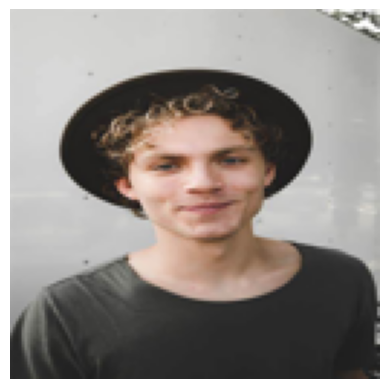

[[2.29077619e-15]]
0


In [42]:
image_path = 'C:/Users/jordi/Documents/Programacion/ANN - Curso2/Proyecto-ANN/DeepLearning-Python/OwnImages/NoCap2.jpg'

predict_solo(image_path, parameters)